In [1]:
#| default_exp app

[LINK](https://www.kaggle.com/competitions/tabular-playground-series-mar-2022/data)

In this competition, you'll forecast twelve-hours of traffic flow in a major U.S. metropolitan area. Time, space, and directional features give you the chance to model interactions across a network of roadways.

Files and Field Descriptions
----------------------------

*   train.csv - the training set, comprising measurements of traffic congestion across 65 roadways from April through September of 1991.

*   row\_id - a unique identifier for this instance
*   time - the 20-minute period in which each measurement was taken
*   x - the east-west midpoint coordinate of the roadway
*   y - the north-south midpoint coordinate of the roadway
*   direction - the direction of travel of the roadway. EB indicates "eastbound" travel, for example, while SW indicates a "southwest" direction of travel.
*   congestion - congestion levels for the roadway during each hour; the target. The congestion measurements have been normalized to the range 0 to 100.

*   test.csv - the test set; you will make hourly predictions for roadways identified by a coordinate location and a direction of travel on the day of 1991-09-30.
*   sample\_submission.csv - a sample submission file in the correct format

Source
------

This dataset was derived from the [Chicago Traffic Tracker - Historical Congestion Estimates](https://www.google.com/url?q=https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Historical-Congestion-Esti/sxs8-h27x&sa=D&source=editors&ust=1679047966796262&usg=AOvVaw0Ubg-W85BHF1zlI4pfmhb6) dataset.

### Imports and Downloading Datasets

In [2]:
#| export
from fastai.tabular.all import *

from sklearn.ensemble import RandomForestRegressor

In [3]:
#| export
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [4]:
#| export
comp = 'tabular-playground-series-mar-2022'
path = setup_comp(comp, install='fastai')

### Transform Data

In [5]:
#| export
train_df = pd.read_csv(path/"train.csv", low_memory=False)
test_df = pd.read_csv(path/"test.csv", low_memory=False)
sample_df = pd.read_csv(path/"sample_submission.csv", low_memory=False)

Combine training and test sets

In [6]:
#| export
comb_df = pd.concat([train_df, test_df]).reset_index(drop=True)

Convert `time` to datetime format and split into separate `date` and `time_of_day` columns

In [7]:
#| export
comb_df['date'] = pd.to_datetime(comb_df.time)

In [8]:
#| export
comb_df['time_of_day'] = comb_df.date.dt.time
comb_df['date'] = comb_df.date.dt.date

In [9]:
#| export
comb_df['time_of_day'] = pd.to_timedelta(comb_df.time_of_day.astype(str))
comb_df['date'] = pd.to_datetime(comb_df.date)


Drop `time` column now that it's been split elsewhere

In [10]:
comb_df.drop(["time"], axis=1 , inplace=True)

In [11]:
comb_df

,row_id,x,y,direction,congestion,date,time_of_day
0,0,0,0,EB,70.0,1991-04-01,0 days 00:00:00
1,1,0,0,NB,49.0,1991-04-01,0 days 00:00:00
2,2,0,0,SB,24.0,1991-04-01,0 days 00:00:00
3,3,0,1,EB,18.0,1991-04-01,0 days 00:00:00
4,4,0,1,NB,60.0,1991-04-01,0 days 00:00:00
...,...,...,...,...,...,...,...
851170,851170,2,3,NB,NaN,1991-09-30,0 days 23:40:00
851171,851171,2,3,NE,NaN,1991-09-30,0 days 23:40:00
851172,851172,2,3,SB,NaN,1991-09-30,0 days 23:40:00
851173,851173,2,3,SW,NaN,1991-09-30,0 days 23:40:00


In [12]:
comb_df = add_datepart(comb_df, 'date')

In [13]:
comb_df

,row_id,x,y,direction,congestion,time_of_day,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,0,0,0,EB,70.0,0 days 00:00:00,1991,4,14,1,0,91,False,True,False,True,False,False,670464000.0
1,1,0,0,NB,49.0,0 days 00:00:00,1991,4,14,1,0,91,False,True,False,True,False,False,670464000.0
2,2,0,0,SB,24.0,0 days 00:00:00,1991,4,14,1,0,91,False,True,False,True,False,False,670464000.0
3,3,0,1,EB,18.0,0 days 00:00:00,1991,4,14,1,0,91,False,True,False,True,False,False,670464000.0
4,4,0,1,NB,60.0,0 days 00:00:00,1991,4,14,1,0,91,False,True,False,True,False,False,670464000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851170,851170,2,3,NB,NaN,0 days 23:40:00,1991,9,40,30,0,273,True,False,True,False,False,False,686188800.0
851171,851171,2,3,NE,NaN,0 days 23:40:00,1991,9,40,30,0,273,True,False,True,False,False,False,686188800.0
851172,851172,2,3,SB,NaN,0 days 23:40:00,1991,9,40,30,0,273,True,False,True,False,False,False,686188800.0
851173,851173,2,3,SW,NaN,0 days 23:40:00,1991,9,40,30,0,273,True,False,True,False,False,False,686188800.0


Get indexes of training(~80%) and validation(~20%) sets

In [14]:
#| export
train_idxs = np.where(train_df.index <= (round(len(train_df) * .8)))
valid_idxs = np.where(train_df.index >= len(train_idxs[0]))
test_idxs = np.where(comb_df.index > train_df.index.max())

In [15]:
#| export
dep_var = 'congestion'

### Create Tabular Pandas Dataset

In [16]:
#| export
procs = [Categorify, FillMissing, Normalize]
cont, cat = cont_cat_split(comb_df, 1, dep_var=dep_var)
train_val_splits = (list(train_idxs[0]), list(valid_idxs[0]))

In [17]:
#| export
to = TabularPandas(comb_df, procs, cat, cont, y_names=dep_var, splits=train_val_splits)

In [18]:
dls = to.dataloaders(1024)

In [19]:
#| export
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [20]:
y = to.train.y

In [21]:
y.min(), y.max()

(0.0, 100.0)

In [22]:
def train_res():
    train_data = pd.read_csv('history.csv')
    return train_data.head(n=50)

In [23]:
learn = tabular_learner(dls, layers=[500, 250], n_out=1, y_range=(0, 100), loss_func=F.l1_loss, cbs=[CSVLogger()])

SuggestedLRs(valley=0.00015848931798245758)

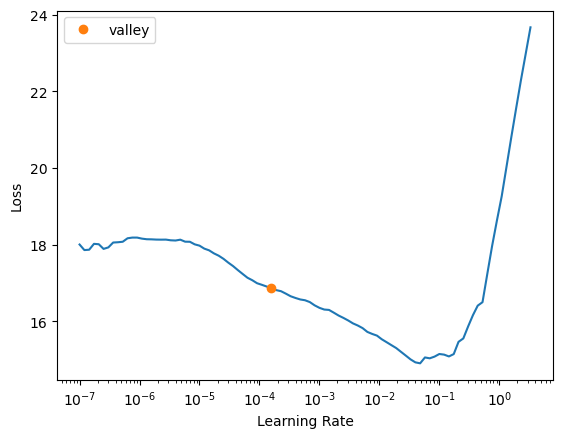

In [24]:
learn.lr_find()

In [25]:
learn.fit_one_cycle(3, 1e-2)
train_res()

epoch,train_loss,valid_loss,time


,epoch,train_loss,valid_loss,time
0,0,6.963368,7.655890,00:09
1,1,6.507038,6.975590,00:06
2,2,6.221701,6.843791,00:07


In [26]:
test_dl = learn.dls.test_dl(comb_df.iloc[test_idxs])

In [27]:
preds = learn.get_preds(dl=test_dl)

In [28]:
preds

(tensor([[54.8738],
         [43.0380],
         [53.4055],
         ...,
         [69.9771],
         [16.4901],
         [42.1431]]),
 tensor([[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]]))

In [29]:
len(test_df)

2340

In [30]:
len(preds[0])

2340

In [31]:
sample_df['congestion'] = preds[0]

In [32]:
sample_df

,row_id,congestion
0,848835,54.873814
1,848836,43.038033
2,848837,53.405464
3,848838,28.594517
4,848839,73.247757
...,...,...
2335,851170,65.848152
2336,851171,32.216461
2337,851172,69.977089
2338,851173,16.490126


In [33]:
submission = sample_df.to_csv("submission.csv", index=False)

In [36]:
!head submission.csv

row_id,congestion
848835,54.873814
848836,43.038033
848837,53.405464
848838,28.594517
848839,73.24776
848840,65.99
848841,44.98659
848842,50.390594
848843,64.39043


In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('submission.csv', 'add date_part', comp)

In [34]:
import nbdev
nbdev.export.nb_export('traffic-flow.ipynb', 'app')
print("export successful")

export successful
